## Init

In [1]:
repo = "https://github.com/ventus550/HandwritingRecognition"
! ! (git status 2> /dev/null) && git clone {repo}
%cd ShapeCorrection

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   ../TkCanvas (untracked content)
	modified:   ETL.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../architectures.py
	../models/new.h5
	train-regressor.ipynb
	../utils.py

no changes added to commit (use "git add" and/or "git commit -a")
[Errno 2] No such file or directory: 'ShapeCorrection'
/home/ventus/Documents/ShapeCorrection/notebooks


In [2]:
import sys
sys.path.append("..")

In [3]:
import keras
from keras.layers import *
import tensorflow as tf

import numpy as np
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import utils
import architectures

2023-04-18 12:40:45.135025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 12:40:45.362121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 12:40:45.365961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 12:40:45.365979: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Configuration

In [4]:
shape = "ellipse"
vertices = 4

In [5]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
DATASET = DESTDIR / "regression" / f"{shape}.npz"
MODLDIR = BASEDIR / "models"

## Data augmentation

In [6]:
def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

def rotate(x, y, angle=30):
    x = np.clip(ndimage.rotate(x, angle=angle, reshape=False), 0, 1)
    centroid = np.zeros(2) + 0.5
    R = rotation_matrix(angle)
    y = centroid + (y - centroid) @ R
    return x, y

def fliplr(x, y):
	x = np.flip(x, axis=1)
	y = ((1, 0) - y) * (1, -1)
	return x, y

def flipud(x, y):
	x = np.flip(x, axis=0)
	y = ((0, 1) - y) * (-1, 1)
	return x, y

def augment(x, y):
    if np.random.rand() < 0.5:
        x, y = fliplr(x, y)
    if np.random.rand() < 0.5:
        x, y = flipud(x, y)
    
    random_angle = np.random.randint(360)
    x, y = rotate(x, y, random_angle)
    return x, y

## Data loading

In [7]:
X, Y  = np.load(DATASET).values()
test  = utils.DataGenerator([X[:100], Y[:100]])
val   = utils.DataGenerator([X[100:200], Y[100:200]])
train = utils.DataGenerator([X[200:], Y[200:]], transform=augment)

In [8]:
def chamfer_distance_loss(points1, points2):
    # Compute pairwise distances between points1 and points2
    distances1 = tf.norm(tf.expand_dims(points1, axis=2) - tf.expand_dims(points2, axis=1), axis=-1)
    distances2 = tf.norm(tf.expand_dims(points2, axis=2) - tf.expand_dims(points1, axis=1), axis=-1)

    # Compute the minimum distances for each point in points1 and points2
    min_distances1 = tf.reduce_min(distances1, axis=-1)
    min_distances2 = tf.reduce_min(distances2, axis=-1)

    # Compute the Chamfer distance loss
    chamfer_loss = tf.reduce_mean(min_distances1, axis=-1) + tf.reduce_mean(min_distances2, axis=-1)

    # Compute the total loss over the entire batch
    return tf.reduce_sum(chamfer_loss)

In [9]:
model = architectures.CNN(vertices)
model.compile(loss=chamfer_distance_loss)

2023-04-18 12:40:48.380131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-18 12:40:48.380156: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-18 12:40:48.380179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-04-18 12:40:48.380385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.fit(train, epochs=1)

195/195 [==============================] - 17s 81ms/step - loss: 14.8154


In [11]:
utils.save(model, MODLDIR / "new.h5", frozen=True)

In [13]:
model = utils.load(MODLDIR / "new.h5")

In [20]:
from shapely.geometry import Polygon

def dice(label, pred, nb_vertices=4):
    y_polygon = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon = Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
    return 2 * I / (y_polygon.area + pred_polygon.area)

TopologyException: Input geom 1 is invalid: Self-intersection at 39.012173971327698 30.400262798903331
TopologyException: Input geom 1 is invalid: Self-intersection at 45.93482304368419 32.615937269829892
TopologyException: Input geom 1 is invalid: Self-intersection at 45.112198165488664 32.076844490812356
TopologyException: Input geom 1 is invalid: Self-intersection at 41.429588846866309 31.009347803430202


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806fa8ac80>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f9d0d90>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f847f40>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f663eb0>


TopologyException: Input geom 1 is invalid: Self-intersection at 27.485876724298528 23.811682074593268
TopologyException: Input geom 1 is invalid: Self-intersection at 46.438330522309272 33.226725770279614
TopologyException: Input geom 1 is invalid: Self-intersection at 28.463057906735806 23.956194689875698


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f728e50>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f701c90>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f180460>


TopologyException: Input geom 1 is invalid: Self-intersection at 45.949170440336601 33.361716260487988
TopologyException: Input geom 1 is invalid: Self-intersection at 40.539061626654984 29.875833686862173
TopologyException: Input geom 1 is invalid: Self-intersection at 23.147866981069814 21.557345603950324
TopologyException: Input geom 1 is invalid: Self-intersection at 45.116258252436715 32.555975365955433


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f564d60>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806fa34e80>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806fab43a0>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f927a90>


TopologyException: Input geom 1 is invalid: Self-intersection at 36.868290823631909 28.927529526928712
TopologyException: Input geom 1 is invalid: Self-intersection at 35.557506838669582 27.983017304549744
TopologyException: Input geom 1 is invalid: Self-intersection at 41.801076757776407 31.935957464883494
TopologyException: Input geom 1 is invalid: Self-intersection at 41.072626564719293 30.265684228724055
TopologyException: Input geom 1 is invalid: Self-intersection at 43.889771742040033 31.071007315142221
TopologyException: Input geom 1 is invalid: Self-intersection at 23.647172085158179 21.198918754574656


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f0649a0>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f087130>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806f0dd990>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806ef2c0d0>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806ef52860>
The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806efad030>


TopologyException: Input geom 1 is invalid: Self-intersection at 42.943033288386211 31.743471977049303


The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f806ee25f90>


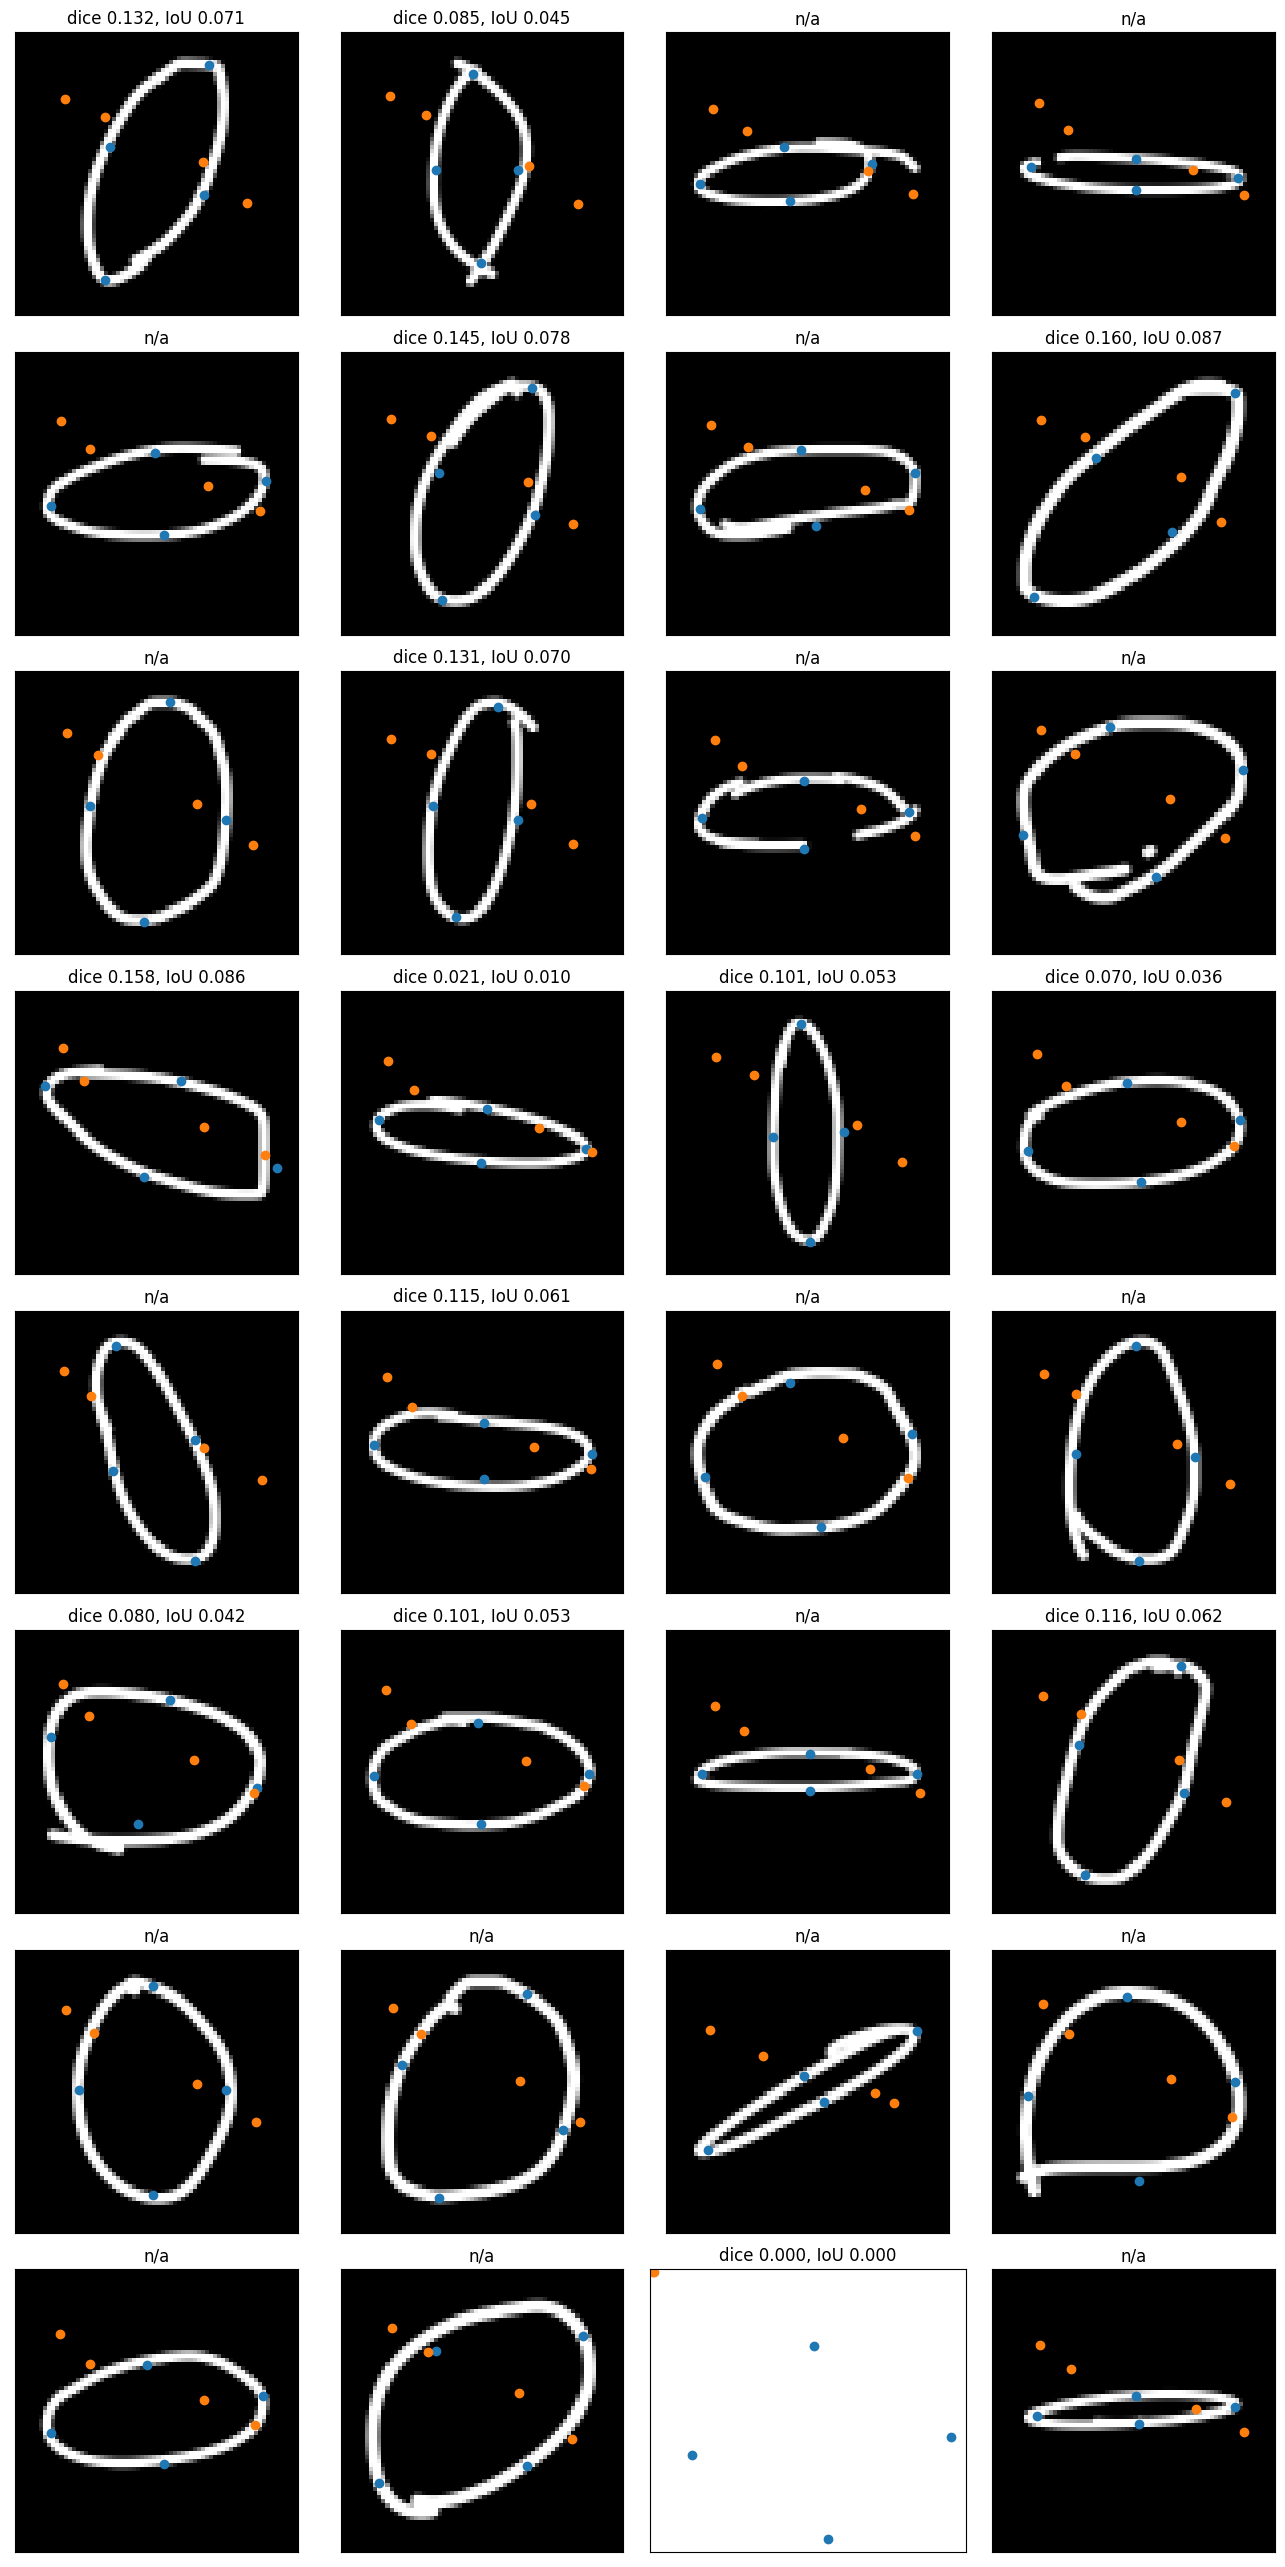

In [21]:
image_size = 70

fig = plt.figure(figsize=(13, 21))
fig.subplots_adjust(hspace=0.13, wspace=0.01, left=0, right=1, bottom=0, top=1.2)
nb_pictures = 32
for irow in range(nb_pictures):
    ipic = np.random.choice(X.shape[0])
    ax = fig.add_subplot(nb_pictures // 4, 4, irow+1, xticks=[],yticks=[]) 
    pred = model(X[ipic].reshape([1, 70, 70, 1]))[0].numpy()
    utils.draw_data_point(X[ipic], Y[ipic], pred, ax)
    try:
        dice = utils.dice(Y[ipic], pred, vertices)
        IoU = utils.IoU(Y[ipic], pred, vertices)
        ax.set_title(f"dice {dice:5.3f}, IoU {IoU:5.3f}")
    except Exception as e:
        ax.set_title("n/a")
plt.show()